## Notebook objectives

Predict Customers who will churn (more than 6 months with no purchases)

## Agenda

[Business Context](#Business-Context)<br> 
&emsp;[Business Questions](#Business-Questions)<br>

[Imports](#Imports)<br>
&emsp;[Helper Functions and Classes](#Helper-Functions-and-Classes)<br>


[Settings](#Settings)<br>

[Loading Data](#Loading-Data)<br>
&emsp;[df_orders_abt](#df_orders_abt)<br>

[Analytical Base Table](#Analytical-Base-Table)<br>
&emsp;[df_churn](#df_churn)<br>
&emsp;[df_customers](#df_customers)<br>

[Feature Selection](#Feature-Selection)<br>

[Preprocessing](#Preprocessing)<br>

[Over Sampling](#Over-Sampling)<br>

[Train Test Split](#Train-Test-Split)<br>

[Random Forest](#Random-Forest)<br>

[Feature Importances](#Feature-Importances)<br>

[Analysis](#Analysis)<br>
&emsp;[Confusion Matrix](#Confusion-Matrix)<br>
&emsp;[Cross Valdiation](#Cross-Valdiation)<br>
&emsp;[Business Impact](#Business-Impact)<br>

[2023 Prediction](#2023-Prediction)<br>


Customer Retention indicates whether the product and the quality of service please existing customers. In order to retain customers, E-Mart aims to predict which customer is going to stop buying.

Data Products asked:

- **A list of customer IDs and their probability of churn.**

- **What's the model performance in predicting customer churn?**

- **What's the monetary return  the model will bring?**

- **What's Customers Churn Rate?**

- **A Dashboard to keep track of Customer Churn and Model's Performance.**



## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import cross_validate

### Helper Functions and Classes

In [2]:
def get_snakecase_columns(df):
    """Sets column name to snake_case format
    
    df: pandas.DataFrame
    
    Return: map
    """
    snakecase = lambda x: str(x).lower().replace(' ', '_').replace('-', '_')
    return map(snakecase, df.columns)

def date(str_date):
    """Apply pandas.to_datetime to argument converting it to datetime.
        
    """
    return pd.to_datetime(str_date)

def find_column(df, col_name):
    """Checks if DataFrame contains a 'column name' and returns the matched columns
    
    df: pandas.DataFrame
    col_name: column name or part of column name to search for
    
    Return: DataFrame with column names that match the col_name searched
    """
    
    df_cols = pd.DataFrame(df.columns, columns=['col_name'])

    return df_cols[df_cols['col_name'].str.contains(col_name)].reset_index(drop=True)


def fig(x=15, y=5, set_as_global=False, reset_to_default=False):
    """ Adjust size of matplotlib figure

    x: figure width.
    y: figure height.
    set_as_global: bool.
        If True, then it sets "x" and "y" axis for all subsequent plots.
    reset_to_default: bool.
        If True, then it resets the global figure size back to default.
    """
    if set_as_global:
        plt.rcParams["figure.figsize"] = (x, y)
    elif reset_to_default:
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    else:
        plt.figure(figsize=(x,y))
        

def train_test_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    return y_pred

## Settings

In [3]:
pd.set_option('display.max_columns', 500)

fig(12,4, set_as_global=True)

## Loading Data

### df_orders_abt

In [4]:
df_orders_abt = pd.read_csv("../../data/growth_analysis/orders_abt.csv")

df_orders_abt['order_date'] = date(df_orders_abt['order_date'])
df_orders_abt['recency'] = (df_orders_abt['order_date'].max() - df_orders_abt['order_date']).dt.days

## Analytical Base Table

### df_churn


A customer is in churn when they have not purchased a product for more than 6 months.

In [5]:
df_churn = df_orders_abt.query("recency < 180")[['customer_id']].drop_duplicates()
df_churn['is_churn'] = False

### df_customers

In [6]:
df_aux = df_orders_abt.query("180 < recency < 900")
CURRENT_DATE = df_aux['order_date'].max()
df_customers = (df_aux
                   .groupby("customer_id")
                   .agg(
                       orders=('order_id', 'nunique'),
                       total_sales=('sales', 'sum'),
                       avg_sales=('sales', 'mean'),
                       total_profit=('profit', 'sum'),
                       avg_profit=('profit', 'mean'),
                       total_products=('n_products', 'sum'),
                       avg_products=('n_products', 'mean'),
                       avg_shipping_cost=('shipping_cost', 'mean'),
                       avg_discount=('avg_discount', 'mean'),
                       profitability=('profitable', 'mean'),
                       delivery_on_time_rate=('delivery_on_time', 'mean'),
                       avg_days_to_ship=('days_to_ship', 'mean'),
                       avg_delivery_time=('delivery_time', 'mean'),
                       recency=('order_date', lambda date: (CURRENT_DATE - date.max()).days)   
                   )
)
df_customers = df_customers.merge(df_churn, how='left', on='customer_id')
df_customers['is_churn'].fillna(True, inplace=True)
df_customers.dropna(inplace=True)
df_customers.head()

,customer_id,orders,total_sales,avg_sales,total_profit,avg_profit,total_products,avg_products,avg_shipping_cost,avg_discount,profitability,delivery_on_time_rate,avg_days_to_ship,avg_delivery_time,recency,is_churn
0,AA-10315,10,20958.058462,2095.805846,103.87640,10.387640,76,7.600000,80.465000,0.105000,0.800000,0.600000,18.555556,24.666667,2,False
1,AA-10375,10,3401.737505,340.173751,-644.34180,-64.434180,65,6.500000,38.714000,0.287500,0.500000,1.000000,18.300000,22.200000,136,False
2,AA-10480,10,77147.268637,7714.726864,967.84830,96.784830,92,9.200000,119.604000,0.062000,0.800000,1.000000,10.000000,14.500000,48,False
3,AA-10645,21,296849.136504,14135.673167,2303.70214,109.700102,159,7.571429,50.748095,0.099183,0.904762,0.952381,11.714286,17.900000,7,False
4,AA-315,4,2187.626955,546.906739,556.70400,139.176000,17,4.250000,53.395000,0.150000,0.750000,1.000000,12.750000,16.250000,58,False


In [7]:
df_customers['is_churn'].mean()

0.1429483088704531

In [8]:
# Training Data = 2 years of transactions... Date up until Jul/2022
# ['is_churn'] column was created based on Jul/2022 until last day of Dec/2022
df_aux['order_date'].min(), df_aux['order_date'].max(), df_orders_abt['order_date'].min(), df_orders_abt['order_date'].max()

(Timestamp('2020-07-15 00:00:00'),
 Timestamp('2022-07-03 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2022-12-31 00:00:00'))

## Feature Selection



In [9]:
# df_customers.columns

In [10]:
response_variable = ['is_churn']
features = ['orders', 'total_sales', 'avg_sales', 'total_profit', 'avg_profit',
            'total_products', 'avg_products', 'avg_shipping_cost', 'avg_discount',
            'profitability', 'delivery_on_time_rate', 'avg_days_to_ship',
            'avg_delivery_time', 'recency']

df_train = df_customers.copy()

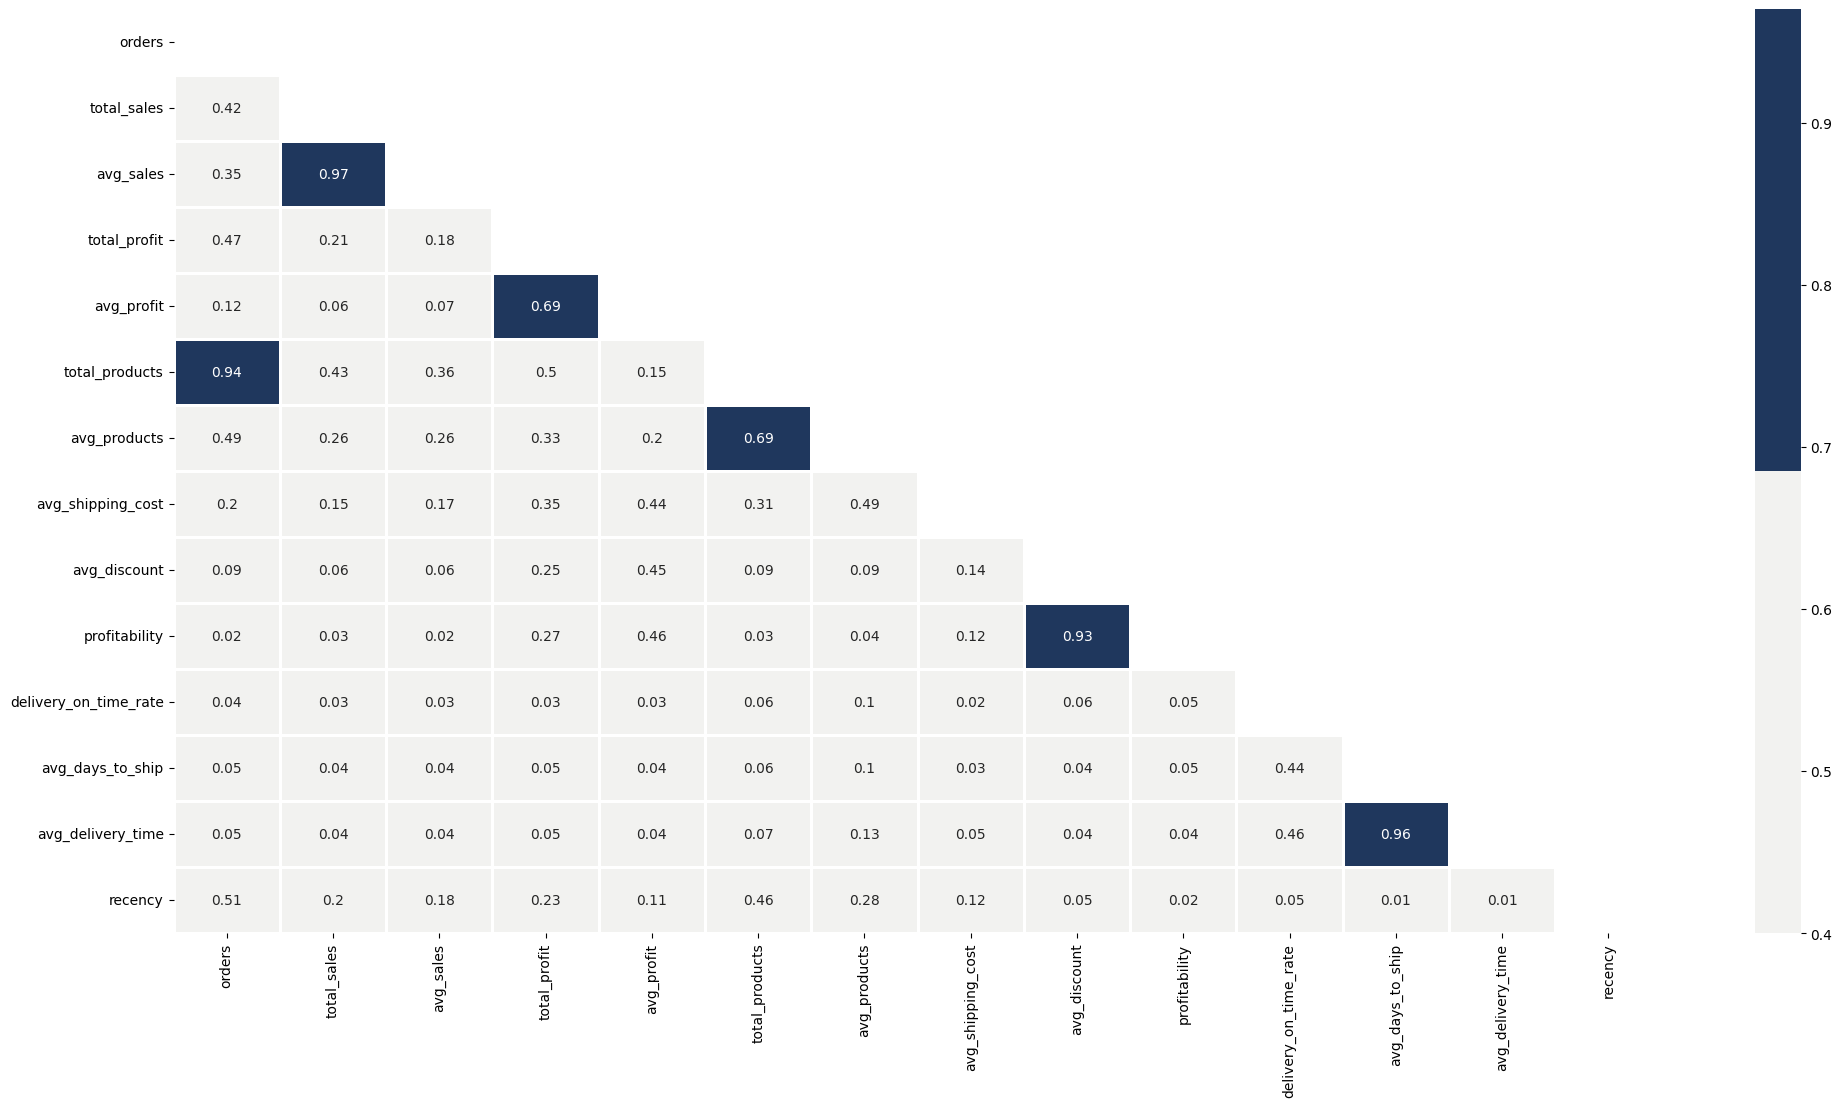

In [11]:
plt.figure(figsize=(24, 12))
correlations = df_train[features].corr().abs().round(2)
mask = np.triu(np.ones_like(correlations, dtype=bool))
sns.heatmap(correlations, mask=mask, linewidths=1, annot=True, cmap=['#F2F2F0','#1F375D'], vmin=0.40) #vmax=-0.40
plt.show()

## Preprocessing

In [12]:
# min_max_scaler = MinMaxScaler()
# df_train = min_max_scaler.fit_transform(df_train)

In [13]:
# df_train = pd.DataFrame(min_max_scaler.fit_transform(df_train),
#                         columns=features)

## Over Sampling

In [14]:
df_train = pd.concat([df_train, df_train.query("is_churn == True")])
df_train['is_churn'].mean()

0.2501395868230039

## Train Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train[response_variable],
                                                    test_size=0.3, random_state=0)

## Random Forest

In [16]:
random_forest_model = RandomForestClassifier(n_estimators=500, min_samples_leaf=10, random_state=0)
random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

C:\Users\Paulo H Sabino\AppData\Local\Temp\ipykernel_13744\245853324.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_model.fit(X_train, y_train)


              precision    recall  f1-score   support

       False       0.85      0.92      0.88       414
        True       0.62      0.45      0.52       124

    accuracy                           0.81       538
   macro avg       0.74      0.68      0.70       538
weighted avg       0.80      0.81      0.80       538



## Feature Importances

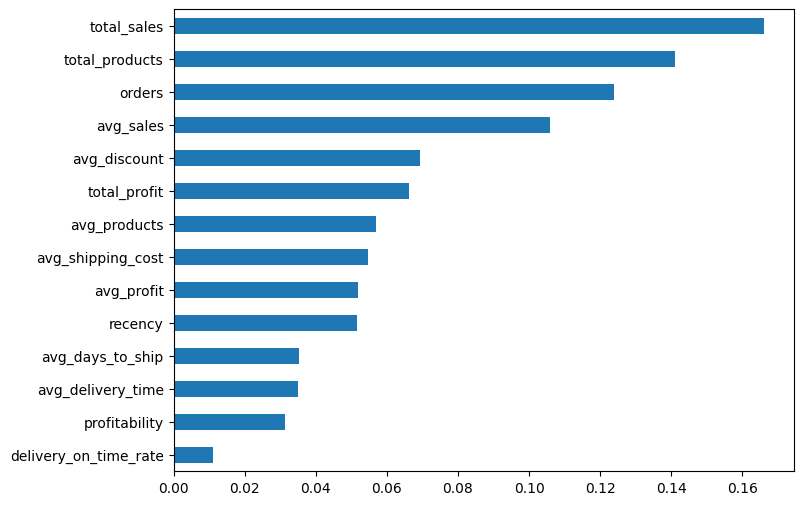

In [17]:
feature_importances = pd.Series(random_forest_model.feature_importances_, index=features).sort_values(ascending=True)
feature_importances.plot.barh(figsize=(8, 6));

## Analysis

In [18]:
model = random_forest_model

## Confusion Matrix

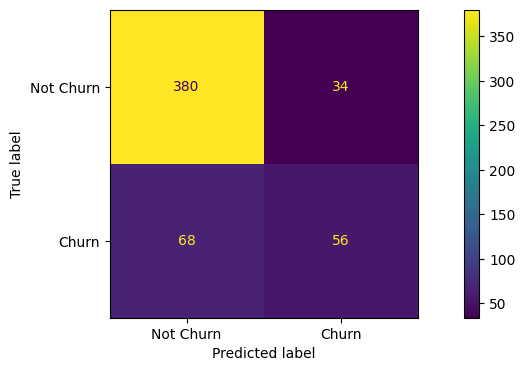

In [19]:
cm = confusion_matrix(y_test, y_pred, labels=[False, True])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churn', 'Churn']).plot()
plt.show()

## Cross Valdiation

In [20]:
%%time
cv = cross_validate(model, df_train[features], df_train[response_variable].values.ravel(), cv=20, scoring=['precision','recall'])
precision = round(cv['test_precision'].mean(), 2)
precision_std = round(cv['test_precision'].std(), 2)
recall = round(cv['test_recall'].mean(), 2)
recall_worst = round(cv['test_recall'].min(), 2)
recall_std = round(cv['test_recall'].std(), 2)
print(f"Precision: {precision} +- {precision_std}")
print(f"Recall:    {recall} +- {recall_std}")

Precision: 0.7 +- 0.09
Recall:    0.46 +- 0.1
CPU times: total: 1min 11s
Wall time: 1min 24s


## Business Impact

In [21]:
churn_rate = df_customers.is_churn.mean().round(4)
number_of_customers = len(df_customers)
numer_of_churned_customers = round(number_of_customers*churn_rate)
avg_churn_ticket = df_customers.query("is_churn == True")['avg_sales'].mean()
avg_number_of_orders = df_customers.query("is_churn == True")['orders'].mean()

print(f"""
    With a {churn_rate * 100}% churn rate.
    We expect that {numer_of_churned_customers} customers will churn.
    
    The model is estimated to identify {round(recall*100, 2)}% of them.
    With a {round(precision*100, 2)}% precision. Witch means: For each 100
    churn alerts the model creates {round(precision*100)} of them will, in fact 
    churn.
    
    Estimated Annual Retained Revenue is $ {round(avg_churn_ticket*numer_of_churned_customers*avg_number_of_orders, 2)/2}
            
""")
# Estimated Annual Retained Revenue divided by 2 because we are using 2 years of data


    With a 14.29% churn rate.
    We expect that 224 customers will churn.
    
    The model is estimated to identify 46.0% of them.
    With a 70.0% precision. Witch means: For each 100
    churn alerts the model creates 70 of them will, in fact 
    churn.
    
    Estimated Annual Retained Revenue is $ 183237.5
            



## Next Steps

Calculate Monthly Churn Rate and use the average as the base churn rate in the Business Impact step

Try other models

Create new features (avg_sales this month, 2 months ago, 3 months ago... percentual change in sales between months)

## 2023 Prediction

Ideally We would save the model, create a script to preprocess the data and then feed this current data to the model. Automating this process.

I'll do this here instead.

In [22]:
df_aux = df_orders_abt.query("recency < 720")
CURRENT_DATE = df_aux['order_date'].max()
df_customers = (df_aux
                   .groupby("customer_id")
                   .agg(
                       orders=('order_id', 'nunique'),
                       total_sales=('sales', 'sum'),
                       avg_sales=('sales', 'mean'),
                       total_profit=('profit', 'sum'),
                       avg_profit=('profit', 'mean'),
                       total_products=('n_products', 'sum'),
                       avg_products=('n_products', 'mean'),
                       avg_shipping_cost=('shipping_cost', 'mean'),
                       avg_discount=('avg_discount', 'mean'),
                       profitability=('profitable', 'mean'),
                       delivery_on_time_rate=('delivery_on_time', 'mean'),
                       avg_days_to_ship=('days_to_ship', 'mean'),
                       avg_delivery_time=('delivery_time', 'mean'),
                       recency=('order_date', lambda date: (CURRENT_DATE - date.max()).days)   
                   )
)
df_customers.dropna(inplace=True)
df_customers.head()

,orders,total_sales,avg_sales,total_profit,avg_profit,total_products,avg_products,avg_shipping_cost,avg_discount,profitability,delivery_on_time_rate,avg_days_to_ship,avg_delivery_time,recency
customer_id,,,,,,,,,,,,,,
AA-10315,13,23999.143019,1846.087925,94.35740,7.258262,88,6.769231,69.375385,0.100000,0.769231,0.615385,16.181818,22.090909,8
AA-10375,13,8337.935422,641.379648,96.87630,7.452023,98,7.538462,43.099231,0.195513,0.615385,0.846154,14.833333,18.750000,6
AA-10480,9,67616.977931,7512.997548,1030.97680,114.552978,81,9.000000,119.530000,0.146667,0.666667,1.000000,11.000000,15.444444,117
AA-10645,21,293699.363633,13985.683983,2281.07734,108.622730,157,7.476190,47.246667,0.129341,0.857143,1.000000,12.333333,19.714286,26
AA-315,6,2213.029796,368.838299,541.41600,90.236000,19,3.166667,35.848333,0.200000,0.666667,1.000000,13.833333,18.000000,2


In [23]:
df_customers['will_churn'] = model.predict(df_customers[features])
df_customers['churn_probability'] = model.predict_proba(df_customers[features])[:, [1]]

# df_customers.reset_index()[['customer_id', 'will_churn', 'churn_probability']].to_csv("../../data/customer_churn/churn_proba.csv", index=False)
df_customers.reset_index()[['customer_id', 'will_churn', 'churn_probability']].head()

,customer_id,will_churn,churn_probability
0,AA-10315,False,0.007965
1,AA-10375,False,0.060931
2,AA-10480,False,0.015333
3,AA-10645,False,0.001445
4,AA-315,False,0.475164


In [24]:
df_customers['will_churn'].value_counts()

will_churn
False    1406
True      174
Name: count, dtype: int64

In [25]:
df_customers.groupby('will_churn').mean()

,orders,total_sales,avg_sales,total_profit,avg_profit,total_products,avg_products,avg_shipping_cost,avg_discount,profitability,delivery_on_time_rate,avg_days_to_ship,avg_delivery_time,recency,churn_probability
will_churn,,,,,,,,,,,,,,,
False,10.743243,58396.162649,3856.486166,641.462280,56.418139,75.182077,6.275376,48.252320,0.131130,0.770911,0.907634,13.286991,18.397050,66.843528,0.174257
True,2.850575,768.290207,265.033317,0.310034,-7.409582,11.448276,4.047806,32.594275,0.318531,0.509182,0.946237,13.451733,18.413556,217.729885,0.590300


Survival Analysis